In [1]:
import numpy as np
import matplotlib.pyplot as plt

from include.load_data.get_counts import get_real_counts_by_county


from include.build_synth import buildData_fromRO as build

from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Univariate import myRt_U
from include.estim import Rt_Multivariate as RtM
from include.estim import laplacianLearning as LL
from include.estim import Rt_MLE as RtMLE

from importlib import reload
reload(RtM), reload(LL)

np.random.seed(2025)

## Disconnected complete graphs (french departments)
Define spatial clusters as disconnected complete graphs, with equal reproduction number in each cluster

In [2]:
firstDay, lastDay = "2020-12-01", "2021-02-10"
dataBasis = 'SPF'
country = "France"
allZData, options = get_real_counts_by_county(firstDay, lastDay, dataBasis)


In [3]:
names_by_clusters = [["85","17","79"],["62","59","80"],["70","25","39"]]

cluster_sizes = [len(cluster) for cluster in names_by_clusters]
nclusters = len(names_by_clusters)

ZData = []
#extract data by depts
for cluster in names_by_clusters:
    for name in cluster:
        id = int(np.where(options["counties"]==name)[0][0])
        ZData.append(allZData[id])
ZData = np.array(ZData)


if np.sum(cluster_sizes)<=10:
    cmap = "tab10"
    colors = plt.get_cmap(cmap)(np.arange(np.sum(cluster_sizes)))
else:
    cmap = "rainbow"
    colors = plt.get_cmap(cmap)(np.linspace(0.05, 0.95,np.sum(cluster_sizes)))


## Generate ZData 
For each country, we generate new cases counts according to the reproduction number of their cluster

First day : 2020-12-01 
 Last day : 2021-02-10


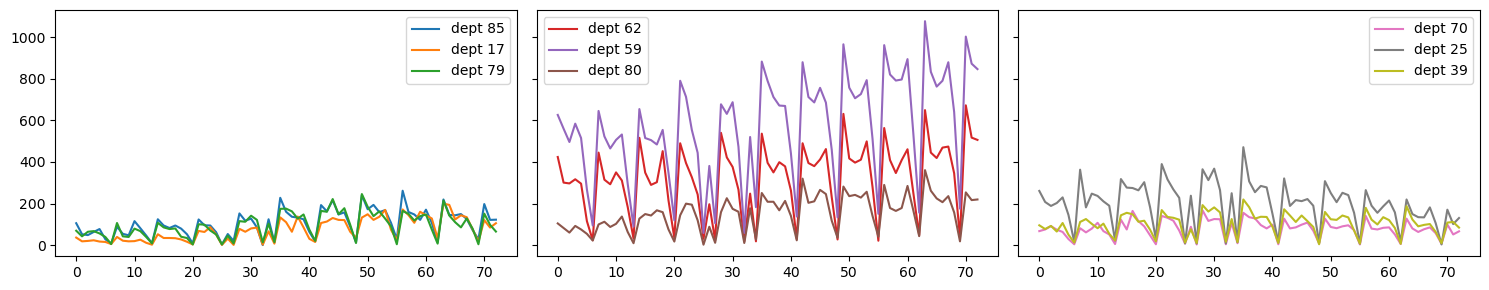

In [4]:
fig, axs = plt.subplots(1,nclusters, figsize=(15,3), sharex=True, sharey="row")
k = 0
for i in range(len(cluster_sizes)):
    for j in range(cluster_sizes[i]):
        axs[i].plot(ZData[k], color=colors[k], label="dept "+names_by_clusters[i][j])
        k+=1
    # axs[i].plot(ZData_by_cluster[i][1:], "k--", label="Original")
    
    axs[i].legend()
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

In [6]:
# get R estim with O as a reference
RestimUO = Rt_U_O(ZData, 3.5, 0.03, options=options)

Computing Univariate estimation with O misreported counts modelisation ...
iter 100000.000000 	 crit=12.983450 

iter 200000.000000 	 crit=12.983176 

Done in 79.3824 seconds ---


In [17]:

n_max_iter = 4

#init param
lambdaU_pwlin = 20
# lambdaU_O = 0.02

#optim param
lambda_Fro = 0.25
lambda_GR = 0.01
lambda_pwlin = 20
Gregularization="L2"

Z = ZData
dates = options["dates"]

Restims = []
Lestims = []

# initialize
R = myRt_U(Z, lambdaU_pwlin, options=options)
# R = []
# for i in range(Z.shape[0]):
#     Ri, _ = RtMLE.Rt_MLE(Z[i], options=options)
#     R.append(Ri)
# R = np.array(R)

Restims.append(R)
for iter in range(n_max_iter):
    print("lambda_GR = {:5.3f}".format(lambda_GR))    
    L = LL.learningL(lambda_GR, lambda_Fro, R)
    R = RtM.Rt_with_laplacianReg(Z, L, lambda_pwlin, lambda_GR, Gregularization, dates)
    lambda_GR = lambda_GR * 5
    Lestims.append(L)
    Restims.append(R)

Computing Univariate estimator ...
Done in 9.1621 seconds ---
lambda_GR = 0.010
Computing Multivariate estimator ...
use prox L2
Done in 31.2517 seconds ---
lambda_GR = 0.050
Computing Multivariate estimator ...
use prox L2
Done in 31.3714 seconds ---
lambda_GR = 0.250
Computing Multivariate estimator ...
use prox L2
Done in 30.1313 seconds ---
lambda_GR = 1.250
Computing Multivariate estimator ...
use prox L2
Done in 39.2183 seconds ---


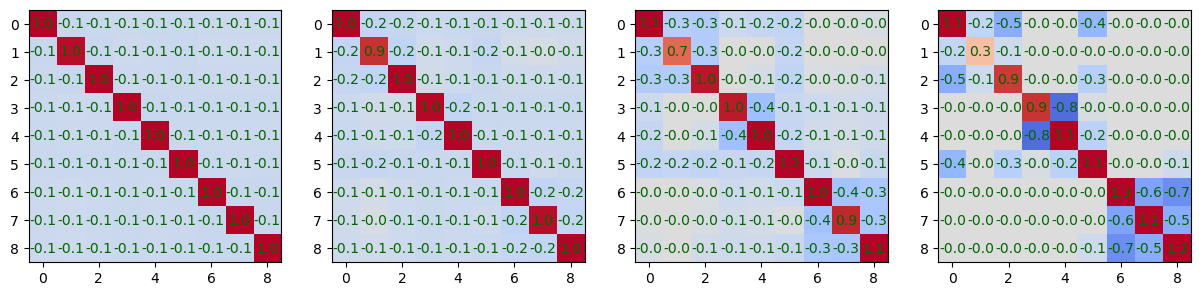

In [18]:
n = Lestims[0].shape[0]
fig, axs = plt.subplots(1, n_max_iter, figsize=(15,5), squeeze=False)
for L, ax in zip(Lestims, axs[0]):
    ax.imshow(L, cmap="coolwarm", vmin=-1, vmax=1)
    for i in range(n):
        for j in range(n):
            c = L[i,j]
            ax.text(i, j, "{:2.1f}".format(c), va='center', ha='center', color="darkgreen")

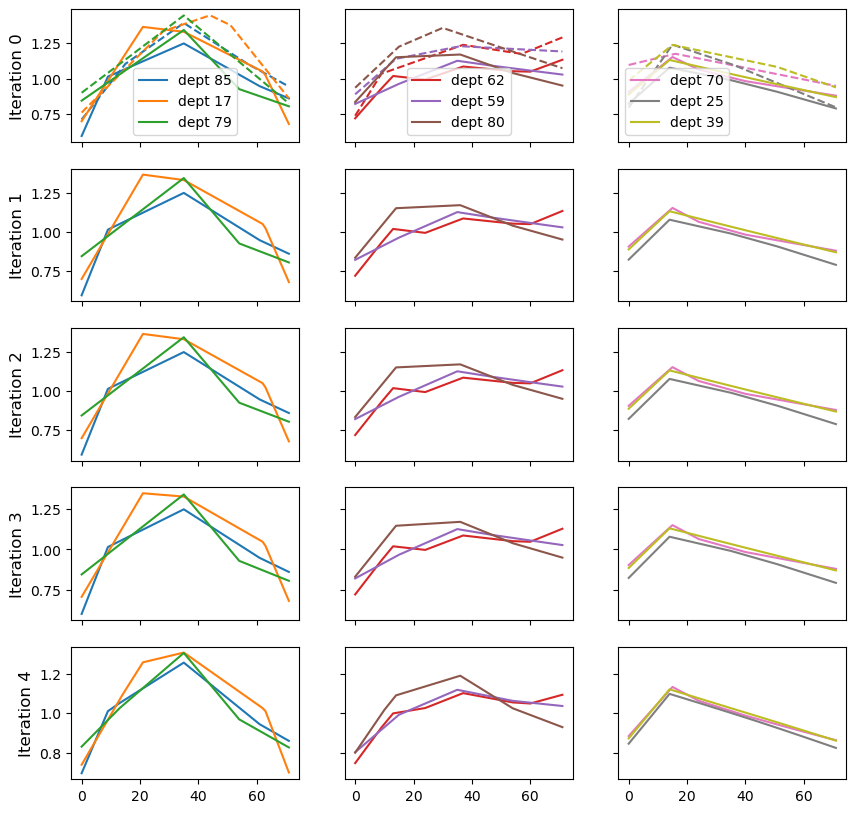

In [19]:
fig, axs = plt.subplots(n_max_iter+1, nclusters, figsize=(10,10), sharex=True, sharey="row", squeeze=False)
for i in range(n_max_iter+1):
    k = 0
    for j in range(nclusters):
        for l in range(cluster_sizes[j]):
            axs[i,j].plot(Restims[i][k], color=colors[k], label="dept "+names_by_clusters[j][l])
            # axs[i,j].plot(Restims[i][k], ':', color=colors[k])
            if i == 0:
                axs[i,j].plot(RestimUO[i][k], "--", color=colors[k])
            k+=1
        if i==0:
            axs[i,j].legend()
        if j==0:
            axs[i,j].set_ylabel("Iteration {}".format(i), fontsize=12)
plt.show()

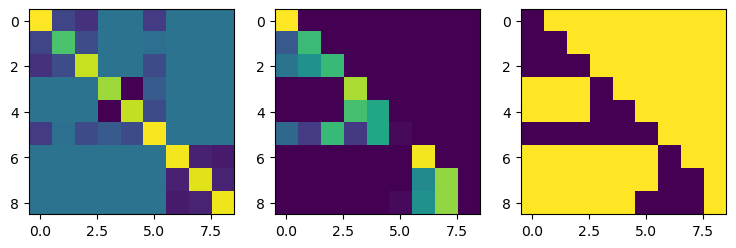

In [ ]:
L = Lestims[1]
U = np.linalg.cholesky(L + (1e-12)*np.eye(L.shape[0]))
# plt.imshow( np.abs(U)<1e-10  )
fig, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].imshow(L)
axs[1].imshow(np.abs(U))
axs[2].imshow(np.abs(U)/np.max(U)<1e-3)